### ***Read Data***

***Station KR289***

In [423]:
import pandas as pd
data =  pd.read_csv("KR289.csv")

In [424]:
data["Pcp"].fillna(0, inplace=True)

In [425]:
data = data[(data.year >= 1980) & (data.year != 2019)]

In [426]:
data.head()

,year,month,day,Pcp,Tmax,Tmin,Wspeed,Rhumidity,Srad,Sshine,Cloud,Tavg
2833,1980,1,1,1.1,5.8,1.3,0.2,0.908,-99.0,0.0,10.0,3.6
2834,1980,1,2,7.3,6.8,3.8,0.1,0.945,-99.0,0.0,10.0,5.4
2835,1980,1,3,0.5,9.2,5.6,1.6,0.845,-99.0,0.4,10.0,7.0
2836,1980,1,4,0.0,6.2,-2.1,3.8,0.498,-99.0,6.2,4.3,3.5
2837,1980,1,5,0.0,3.0,-5.9,2.3,0.525,-99.0,7.9,0.0,-2.3


In [427]:
data = data[["year", "month", "day", "Pcp", "Rhumidity","Tavg", "Tmax", "Tmin"]]
data = data.dropna()

In [428]:
data.head()

,year,month,day,Pcp,Rhumidity,Tavg,Tmax,Tmin
2833,1980,1,1,1.1,0.908,3.6,5.8,1.3
2834,1980,1,2,7.3,0.945,5.4,6.8,3.8
2835,1980,1,3,0.5,0.845,7.0,9.2,5.6
2836,1980,1,4,0.0,0.498,3.5,6.2,-2.1
2837,1980,1,5,0.0,0.525,-2.3,3.0,-5.9


In [429]:
data  = data[data['Rhumidity'] != -99.0]

In [430]:
data['Rhumidity'] = data.apply(lambda row: row['Rhumidity'] * 100 if row['year'] < 2019 else row['Rhumidity'], axis=1)

***Drop rows with NAN***

In [431]:
data.shape

(15337, 8)

### ***Calculate Dewpoint temperaature***

In [432]:
import math
def calculate_dewpoint(temp, humidity):
    A = 17.27
    B = 237.7
    alpha = ((A * temp) / (B + temp)) + math.log(humidity/100.0)
    return (B * alpha) / (A - alpha)

In [433]:
data['Tdew'] = data.apply(lambda row: calculate_dewpoint(row['Tavg'], row['Rhumidity']), axis=1)
data.head()

,year,month,day,Pcp,Rhumidity,Tavg,Tmax,Tmin,Tdew
2833,1980,1,1,1.1,90.8,3.6,5.8,1.3,2.238829
2834,1980,1,2,7.3,94.5,5.4,6.8,3.8,4.588320
2835,1980,1,3,0.5,84.5,7.0,9.2,5.6,4.567805
2836,1980,1,4,0.0,49.8,3.5,6.2,-2.1,-5.991340
2837,1980,1,5,0.0,52.5,-2.3,3.0,-5.9,-10.688035


In [434]:
data['Date'] = pd.to_datetime(data[['year', 'month', 'day']], errors='coerce')

In [435]:
data.head()

,year,month,day,Pcp,Rhumidity,Tavg,Tmax,Tmin,Tdew,Date
2833,1980,1,1,1.1,90.8,3.6,5.8,1.3,2.238829,1980-01-01
2834,1980,1,2,7.3,94.5,5.4,6.8,3.8,4.588320,1980-01-02
2835,1980,1,3,0.5,84.5,7.0,9.2,5.6,4.567805,1980-01-03
2836,1980,1,4,0.0,49.8,3.5,6.2,-2.1,-5.991340,1980-01-04
2837,1980,1,5,0.0,52.5,-2.3,3.0,-5.9,-10.688035,1980-01-05


### ***Binning Method***

In [436]:
# Define the precipitation intensity threshold for rain days
precipitation_threshold = 0.1

rain_days = data[data['Pcp'] > precipitation_threshold]

num_bins = 20

In [437]:
# Apply equal-frequency binning to the temperature data for rain days
rain_days['Temperature_Bins'] = pd.qcut(rain_days['Tdew'], q=num_bins, labels=False, duplicates='drop')

C:\Users\USER2\AppData\Local\Temp\ipykernel_28488\3368197447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rain_days['Temperature_Bins'] = pd.qcut(rain_days['Tdew'], q=num_bins, labels=False, duplicates='drop')


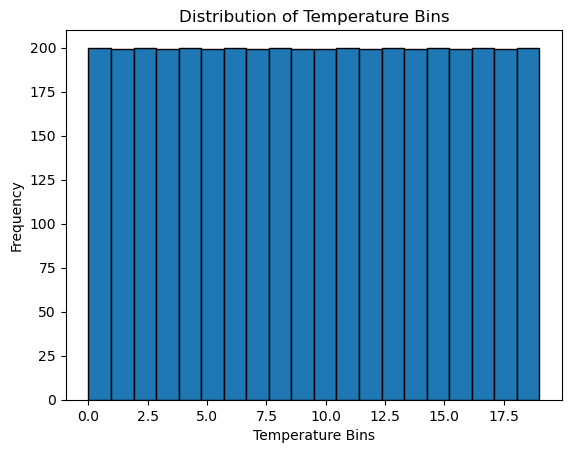

In [438]:
import matplotlib.pyplot as plt
bin_counts = rain_days['Temperature_Bins'].value_counts().sort_index()
plt.hist(rain_days['Temperature_Bins'], bins=num_bins, edgecolor='black')
plt.xlabel('Temperature Bins')
plt.ylabel('Frequency')
plt.title('Distribution of Temperature Bins')
plt.show()

In [439]:
# Calculate P99 for precipitation in each temperature bin
p99_precipitation = rain_days.groupby('Temperature_Bins')['Pcp'].quantile(0.99)

# Calculate mean temperature in each bin
mean_dew_temperature = rain_days.groupby('Temperature_Bins')['Tdew'].mean()

result_df = pd.DataFrame({'Mean_Dew_Temperature': mean_dew_temperature, 'P99_Precipitation': p99_precipitation})

result_df

,Mean_Dew_Temperature,P99_Precipitation
Temperature_Bins,,
0,-6.772735,13.050
1,-2.074207,31.588
2,0.428707,33.533
3,2.389970,39.584
4,4.421596,40.505
5,6.588461,59.020
6,8.425504,69.735
7,10.294340,86.634
8,12.039077,80.592


***Fit log(P99) and Mean Dew in each bin to estimate beta***

$log(P99) = \alpha + \beta T$

In [440]:
import numpy as np

result_df['Log_P99'] = np.log(result_df['P99_Precipitation'])

In [441]:
result_df

,Mean_Dew_Temperature,P99_Precipitation,Log_P99
Temperature_Bins,,,
0,-6.772735,13.050,2.568788
1,-2.074207,31.588,3.452777
2,0.428707,33.533,3.512530
3,2.389970,39.584,3.678425
4,4.421596,40.505,3.701425
5,6.588461,59.020,4.077876
6,8.425504,69.735,4.244702
7,10.294340,86.634,4.461692
8,12.039077,80.592,4.389399


In [442]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(result_df['Mean_Dew_Temperature'], result_df['Log_P99'])

In [443]:
slope

0.0826278778175079

***Calculate Scaling Rate***

$100(e^\beta-1)$

In [444]:
scaling_rate_tdew = 100*((math.e)**(slope) - 1)

In [445]:
scaling_rate_tdew 

8.613755745913586

### ***Quantile Regression***

In [446]:
import statsmodels.api as sm

quantile = 0.99

model_Pcp = sm.QuantReg(np.log(rain_days['Pcp']), sm.add_constant(rain_days[['Tdew']])).fit(q=quantile)

In [447]:
print(model_Pcp.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    Pcp   Pseudo R-squared:               0.1323
Model:                       QuantReg   Bandwidth:                      0.5900
Method:                 Least Squares   Sparsity:                        25.65
Date:                Thu, 07 Dec 2023   No. Observations:                 3990
Time:                        17:48:29   Df Residuals:                     3988
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5271      0.066     53.056      0.000       3.397       3.657
Tdew           0.0850      0.004     20.407      0.000       0.077       0.093


In [448]:
slope = model_Pcp.params[1]

In [449]:
scaling_rate = 100*((math.e)**(slope) - 1)
scaling_rate 

8.873320356414105

### ***Zhang Method***

In [468]:
grouped_df = data.groupby(['year', 'month'])

max_indices = grouped_df.apply(lambda x: x['Pcp'].idxmax())

monthly_max = data.loc[max_indices]

In [469]:
from pykelihood.distributions import GEV 
from pykelihood import kernels

In [470]:
avg_tdew = data.groupby(['year', 'month'])['Tdew'].mean().reset_index()

In [471]:
fitted_gev = GEV.fit(monthly_max["Pcp"], loc=kernels.linear(monthly_max["Tdew"]))
fitted_gev

GEV(loc=linear(a=14.760374320660816, b=1.1197371665343854), scale=19.96820486184123, shape=0.3589854167596139)

In [472]:
non_zero = data[data["Pcp"] != 0]
median_pcp = non_zero['Pcp'].median()
monthly_max['Pcp_normalized'] = monthly_max['Pcp'] / median_pcp 

In [473]:
# Tdew anomalies 
mean_tdew = data["Tdew"].mean()
# Calculate dew point temperature anomalies
monthly_max['Tdew_anomaly'] = monthly_max['Tdew'] - mean_tdew

In [474]:
fitted_gev = GEV.fit(monthly_max["Pcp_normalized"], loc=kernels.linear(monthly_max["Tdew_anomaly"]))
fitted_gev

c:\Users\USER2\anaconda3\Lib\site-packages\pykelihood\distributions.py:69: RuntimeWarning: divide by zero encountered in log
  return np.log(self.pdf(x))


GEV(loc=linear(a=4.6148920532472815, b=0.2332780799959797), scale=4.160038936203491, shape=0.358987042490462)

In [475]:
fitted_gev.param_dict["loc"].flattened_param_dict["b"]

0.2332780799959797

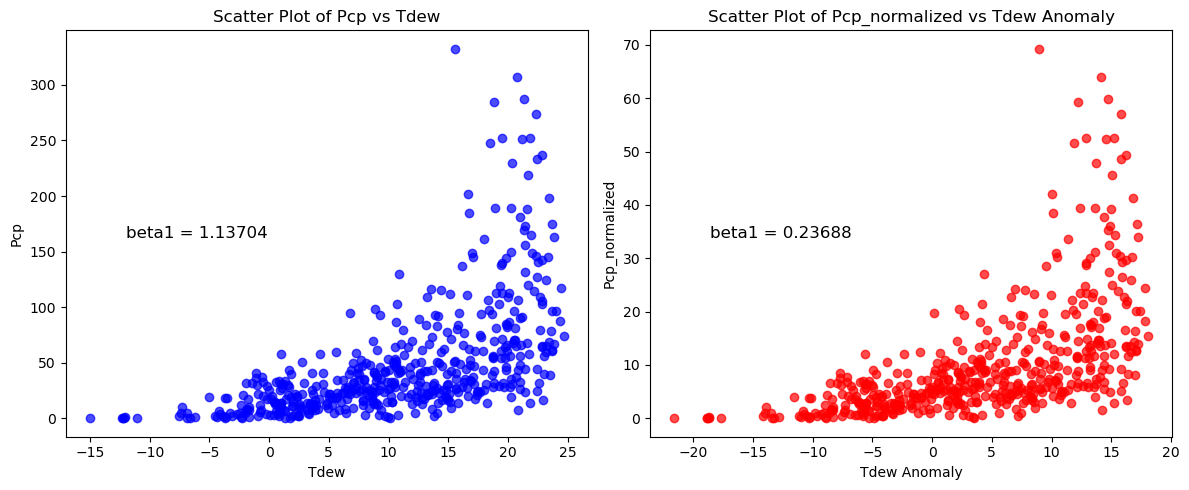

In [476]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax1.scatter(monthly_max['Tdew'], monthly_max['Pcp'], label='Pcp vs Tdew', color='blue', alpha=0.7)
ax1.set_xlabel('Tdew')
ax1.set_ylabel('Pcp')
ax1.set_title('Scatter Plot of Pcp vs Tdew')
ax1.text(0.25, 0.5, f"beta1 = {1.1370400223304005:.5f}", transform=ax1.transAxes, fontsize=12, ha='center', va='center')

ax2.scatter(monthly_max['Tdew_anomaly'], monthly_max['Pcp_normalized'], label='Pcp_normalized vs Tdew', color='red', alpha=0.7)
ax2.set_xlabel('Tdew Anomaly')
ax2.set_ylabel('Pcp_normalized')
ax2.set_title('Scatter Plot of Pcp_normalized vs Tdew Anomaly')
ax2.text(0.25, 0.5, f"beta1 = {0.23688050054357657:.5f}", transform=ax2.transAxes, fontsize=12, ha='center', va='center')
plt.tight_layout()

# Show the plot
plt.show()

